# LSTM을 이용한 StackOverflow의 질문 수 예측

Dataset : MLTollsStackOverflow.csv (2009년 ~ 2019년 까지의 월별 stackoverflow 질문 수 데이터)

출처 : https://www.kaggle.com/aishu200023/stackindex

### 연구 배경
**이 연구는 [과제 3] 선형회귀를 이용한 데이터 분석에 이어 LSTM을 활용하여 질문수를 예측해 보았습니다. 따라서 데이터 전처리 과정은 [과제 3]을 활용하였습니다.**

StackOverflow는 컴퓨터 공학 전공자들이 애용하는 대표적인 사이트 중 하나로 프로그래밍을 하기위한 지식 또는 에러, 심지어는 코드에 대한 직접적인 질문도 올라오는 사이트 중 하나입니다.
이곳에 올라오는 질문 수를 통해 얼마나 컴퓨터공학 또는 프로그램밍에 대한 사람들의 관심이 높아져 왔는지를 확인할 수 있다고 생각하여 본 프로젝트를 준비해 보았습니다.

In [299]:
import numpy as np
import pandas as pd
import time
import datetime

In [300]:
# data load
df = pd.read_csv("MLTollsStackOverflow.csv")
df.head()

,month,nltk,spacy,stanford-nlp,python,r,numpy,scipy,matlab,machine-learning,...,Plato,Sympy,Flair,stanford-nlp.1,pyqt,Nolearn,Lasagne,OCR,Apache-spark-mlib,azure-virtual-machine
0,09-Jan,0,0,0,631,8,6,2,19,8,...,0,1,0,0,5,0,0,5,0,0
1,09-Feb,1,0,0,633,9,7,3,27,4,...,0,0,0,0,5,0,0,11,0,0
2,09-Mar,0,0,0,766,4,4,2,24,3,...,0,0,0,0,7,0,0,2,0,0
3,09-Apr,0,0,0,768,12,6,3,32,10,...,0,0,0,0,11,0,0,5,0,0
4,09-May,1,0,0,1003,2,7,2,42,7,...,0,0,0,0,10,0,0,3,0,0


In [301]:
# 데이터 전처리
def process_month(date: str):
    # 선형회귀를 하기 위해서 timestamp data가 필요함
    month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    for idx, m_str in enumerate(month):
        date = date.replace(m_str, str(idx+1))
    return time.mktime(datetime.datetime.strptime(date, "%y-%m").timetuple())

month = df["month"]
month_timestamp = df['month'].apply(process_month)
questions = df.iloc[:,1:].sum(axis=1) # 질문들의 수를 다 더해준다.
processed_df = pd.concat([month, month_timestamp, questions], axis=1, keys=["month", "month_timestamp", "questions"])
processed_df.head()

,month,month_timestamp,questions
0,09-Jan,1.230736e+09,832.0
1,09-Feb,1.233414e+09,893.0
2,09-Mar,1.235833e+09,1001.0
3,09-Apr,1.238512e+09,1053.0
4,09-May,1.241104e+09,1323.0


<AxesSubplot:xlabel='month'>

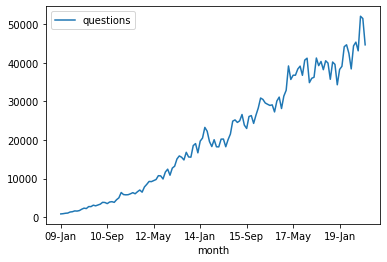

In [302]:
# 월별 질문 수 그래프
processed_df.plot(x="month", y="questions")

## 데이터 셋 만들기

In [303]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

,month_timestamp,questions
0,0.000000,0.000000
1,0.007777,0.001191
2,0.014802,0.003299
3,0.022579,0.004314
4,0.030105,0.009584


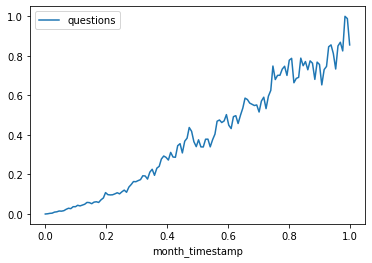

In [304]:
# preprocessing for LSTM
# 모델 학습이 수월하도록 정규화 수행 (Learning Dynamics를 높이기 위해서 정규화 수행)
scaler = MinMaxScaler()
scale_cols = ["month_timestamp","questions"]
scaled_df = pd.DataFrame(scaler.fit_transform(processed_df[scale_cols]))
scaled_df.columns = scale_cols

scaled_df.plot(x="month_timestamp", y="questions")
scaled_df.head()

### Data Lodaer를 만들기 위한 두 가지 방법
pytorch에서 학습을 위해 데이터를 가장 간단하게 가져오는 방법 중 하나는 Dataloader를 이용하는 것입니다.
따라서 [과제 4]에서도 Dataloader를 활용하였고 이번 역시 [과제 4]와 동일한 방식으로 학습을 진행하기 위해 Dataloader를 만들었습니다.

또한 sequential data를 처리하는 경우에는 하나의 현상을 input과 ouput으로 나누어야 학습을 진행시킬 수 있습니다.
그렇기 때문에 데이터를 input과 output으로 분리하는 과정을 추가해야 하는데, 이를 두가지 관점으로 접근할 수 있습니다.
첫번째 관점은 **객체지향적 관점**이고(방법 1), 두번째 관점은 **절차지향적 관점**(방법 2)입니다.

(두 관점 모두 장단점이 있기 때문에, 두 관점 모두 구현해 보았습니다 :)

In [305]:
TEST_SIZE = 32
# time-series data에서는 사실 input과 output의 구분은 없고, 결과만 있을 뿐이다
# 따라서 input과 output을 구분하기 위해서는 과거 며칠을 기반으로 예측을 할지 정해주어야 한다. => window size
WINDOW_SIZE = 15
BATCH_SIZE = 2
TRAIN_RATIO = 0.8
SEED = 42

# 학습과 테스트를 위한 데이터 셋 분리 (검증용)
train_df = scaled_df[:-TEST_SIZE].copy()
test_df = scaled_df[-TEST_SIZE:].copy()

#### [방법 1] Dataset을 상속하여 구현하는 방법

In [306]:
class QuestionDataset(Dataset):
    def __init__(self, data, window_size=15):
        feature_cols = ["month_timestamp"]
        label_cols = ["questions"]
        self.inputs = data[feature_cols]
        self.label = data[label_cols]
        self.window_size = window_size

    def __len__(self):
        return len(self.inputs) - self.window_size

    def __getitem__(self, idx):
        # 참고 : input(x값)은 window 크기 만큼의 "기간"을 넣어줄 것입니다. (현재 x 데이터가 "기간" 밖에 없기 때문입니다.)
        inputs = torch.zeros(self.window_size, 1)
        for i in range(0, self.window_size):
            inputs[i] = torch.tensor(self.inputs.iloc[idx+i])

        # 참고 : target(y값)은 input의 포함된 달들 중 마지막 달의 다음 달의 question의 개수입니다.
        #       예를들어, window size가 15이니 2009년 1월 ~ 2010년 3월까지의 데이터를 input(x)으로 넣고 2010년 4월의 question 개수(y)를 줍니다.
        target = torch.tensor(self.label.iloc[idx + self.window_size])
        return inputs.float(), target.float()

def get_dataloader(dataset, batch_size=BATCH_SIZE):
    # For Debugging
    torch.manual_seed(42)

    # train set과 validation set을 랜덤하게 할당
    train_cnt = int(len(dataset) * TRAIN_RATIO)
    val_cnt = len(dataset) - train_cnt

    _train, _val = torch.utils.data.random_split(dataset, [train_cnt, val_cnt])

    # data loader 만들기
    _train_loader = DataLoader(_train, batch_size=batch_size, shuffle=True)
    _valid_loader = DataLoader(_val, batch_size=1, shuffle=False)
    return _train_loader, _valid_loader

train_dataset = QuestionDataset(train_df, WINDOW_SIZE)
test_dataset = QuestionDataset(test_df, WINDOW_SIZE)
train_loader, valid_loader = get_dataloader(train_dataset)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 데이터 확인
for inputs, label in valid_loader:
    print(inputs.shape, label.shape)

torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])


#### [방법 2] 함수를 만들어 input과 output을 분리한 뒤 dataloader를 만드는 방법

In [232]:
# input과 output을 나누어 줌
def make_dataset(data, label, window_size=15):
    features = []
    labels = []

    for i in range(len(data) - window_size):
        features.append(data.iloc[i:i+window_size]) # input(x)
        labels.append(label.iloc[i+window_size]) # output(y)

    return  np.array(features), np.array(labels)

feature_cols = ["month_timestamp"]
label_cols = ["questions"]

#train_feature, train_label = make_dataset(scaled_df[feature_cols], scaled_df[label_cols], WINDOW_SIZE) # 미래 예측용(쓰지 않을 예정)
train_feature, train_label = make_dataset(train_df[feature_cols], train_df[label_cols], WINDOW_SIZE) # (검증용)
x_test, y_test = make_dataset(test_df[feature_cols], test_df[label_cols], WINDOW_SIZE)

# 데이터 셋 만들기
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train).float(), torch.tensor(y_train).float())
valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_valid).float(), torch.tensor(y_valid).float())
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_test).float(), torch.tensor(y_test).float())

# 데이터 로더 만들기
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 데이터 확인
for inputs, label in valid_loader:
    print(inputs.shape, label.shape)

torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])
torch.Size([1, 15, 1]) torch.Size([1, 1])


#### 모델 정의

참고 : https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
* Dataloader와 모델 사이의 차원을 맞추기 위해 참고하였습니다.

In [364]:
import torch
import torch.nn as nn

In [365]:
HIDDEN_SIZE = 64
NUM_LAYERS = 5
INPUT_SIZE = 1 # feature들의 개수
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class QuestionLSTM(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
        super(QuestionLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):

        #h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # [D * num_layers, N(batch_size), H]
        #c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # [D * num_layers, N, H]
        #output, (h_n, c_n) = self.lstm,(x, (h_0, c_0)) # x : [N, L, H]

        output, (h_n, c_n) = self.lstm(x) # x : [N, L, H]
        h_out = output[:,-1,:]
        out = self.fc1(h_out)
        out = self.fc2(out)
        out = self.dropout(out)

        return out

#### LSTM Trainer

In [366]:
import torch.optim as optim
import torch.nn as nn
import copy

from torch.optim import lr_scheduler
from fastprogress import progress_bar

In [367]:
NUM_OF_EPOCH = 500

model = QuestionLSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)

best_model_weights = copy.deepcopy(model.state_dict())
best_loss = float("inf")

In [368]:
for epoch in progress_bar(range(NUM_OF_EPOCH)):
    model.train()

    running_loss = 0.0
    evaluation_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # 이전에 구했던 기울기를 0으로 초기화 함
        outputs = model(inputs) # 네트워크를 통과시킴 => computational graph가 만들어짐
        loss = criterion(outputs, labels)

        # back-propagation
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item() * inputs.size(0))

    # Evaluate on validation set
    # 사실 이런 식으로(scheduler에 valdation loss를 주는 방식) validation set을
    # 이용해 learning rate를 조정하면 validation set에 overfitting 될 수 있습니다.
    # 따라서, 실제 모델의 성능을 측정하기 위해서는 test set을 사용해야 합니다.
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            scheduler.step(loss)

            evaluation_loss += float(loss.item() * inputs.size(0))

    epoch_loss = running_loss / len(train_loader.dataset)
    valid_loss = evaluation_loss / len(valid_loader.dataset)

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_weights = copy.deepcopy(model.state_dict())

    if epoch % 10 == 0 or epoch == NUM_OF_EPOCH-1:
        print('Epoch {}/{} : {} Loss: {:.4f} Valid Loss : {:.4f}'.format(
            epoch + 1, NUM_OF_EPOCH, "train", epoch_loss, valid_loss),)


Epoch 1/500 : train Loss: 0.0646 Valid Loss : 0.0249
Epoch 11/500 : train Loss: 0.0345 Valid Loss : 0.0011
Epoch 21/500 : train Loss: 0.0415 Valid Loss : 0.0036
Epoch 31/500 : train Loss: 0.0284 Valid Loss : 0.0019
Epoch 41/500 : train Loss: 0.0215 Valid Loss : 0.0035
Epoch 51/500 : train Loss: 0.0308 Valid Loss : 0.0054
Epoch 61/500 : train Loss: 0.0227 Valid Loss : 0.0047
Epoch 71/500 : train Loss: 0.0321 Valid Loss : 0.0040
Epoch 81/500 : train Loss: 0.0487 Valid Loss : 0.0024
Epoch 91/500 : train Loss: 0.0192 Valid Loss : 0.0042
Epoch 101/500 : train Loss: 0.0221 Valid Loss : 0.0023
Epoch 111/500 : train Loss: 0.0338 Valid Loss : 0.0037
Epoch 121/500 : train Loss: 0.0122 Valid Loss : 0.0027
Epoch 131/500 : train Loss: 0.0255 Valid Loss : 0.0034
Epoch 141/500 : train Loss: 0.0249 Valid Loss : 0.0030
Epoch 151/500 : train Loss: 0.0290 Valid Loss : 0.0033
Epoch 161/500 : train Loss: 0.0154 Valid Loss : 0.0033
Epoch 171/500 : train Loss: 0.0425 Valid Loss : 0.0031
Epoch 181/500 : train

In [370]:
# save model weight
torch.save(best_model_weights, './weights/best_weights.pth')

# 결과 확인

In [371]:
weight_path = './weights/best_weights.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 모델 구성후 학습된 파라미터 로드
model = QuestionLSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
model.load_state_dict(torch.load(weight_path))
model.to(device)

QuestionLSTM(
  (lstm): LSTM(1, 64, num_layers=5, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [372]:
def predict(dataloader, model):
    model.eval()
    total_output = torch.tensor([]).to(device)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            outputs = model(inputs)

            total_output = torch.cat((total_output, outputs), dim=0)

    return total_output

y_hat_col = "Model predication"
_train_df = train_df.iloc[WINDOW_SIZE:].copy()
#_train_df = train_df.loc[:, ("month_timestamp", "questions")]
_test_df = test_df.iloc[WINDOW_SIZE:].copy()
#_test_df = test_df.loc[WINDOW_SIZE:, ("month_timestamp", "questions")]

_train_df[y_hat_col] = predict(DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False), model).cpu().numpy()
_test_df[y_hat_col] = predict(test_loader, model).cpu().numpy()

In [373]:
_train_df.head()

,month_timestamp,questions,Model predication
15,0.114150,0.040953,0.049690
16,0.121676,0.045170,0.051925
17,0.129453,0.049406,0.054252
18,0.136979,0.058600,0.056698
19,0.144757,0.057721,0.059248


In [374]:
_test_df

,month_timestamp,questions,Model predication
115,0.877822,0.763083,0.617895
116,0.885600,0.681060,0.623805
117,0.893126,0.768373,0.629602
118,0.900903,0.756408,0.635297
119,0.908430,0.653243,0.640876
120,0.916207,0.730680,0.646338
121,0.923984,0.746647,0.651696
122,0.931009,0.845986,0.656937
123,0.938786,0.855551,0.662069
124,0.946312,0.812157,0.667080


## 결과 시각화

In [386]:
total_df = pd.concat((_train_df, _test_df))
total_df.head()

,month_timestamp,questions,Model predication
15,0.114150,0.040953,0.049690
16,0.121676,0.045170,0.051925
17,0.129453,0.049406,0.054252
18,0.136979,0.058600,0.056698
19,0.144757,0.057721,0.059248


<AxesSubplot:xlabel='month_timestamp'>

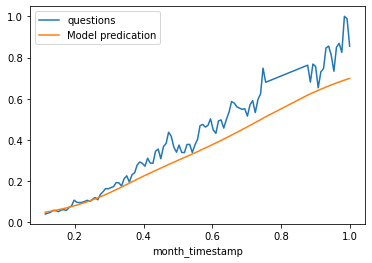

In [385]:
# 실제 그래프
total_df.plot(x="month_timestamp", y=["questions","Model predication"])

## 간단한 분석
* 데이터셋의 크기가 조금 더 컸다면 좀 더 큰 window size를 정할 수 있어서 정확도가 올라갈 것이라고 생각합니다.
* 시각화 해봤을 때 비교적 결과가 Deterministic 했기 때문에 CNN을 같이 활용했으면 조금 더 좋은 결과가 나올 수 있었을 것이라고 생각합니다.(이번 과제는 RNN 과제이기 때문에 CNN을 활용하지 않았습니다)